# Word2Vec 

The word2vec is based on two central ideas - Skipgram and negative sampling. 
1. It is a two layer NN whihc takes one-hot encoding of the words in our trining data. 
2. The number of neurons in hidden layers shows the length of embeddings (300 neurons needed if words are represented by a 300 length vector). 500 is typically used
3. The output is the probability of te target word
4. After the model is trained, the final weigth matrix is treated as word embeddigs i.e., each word having a set of n (300 in exampe above) weigths.
An article to go through: [The Illustrated Word2vec by Jay Alammar](https://jalammar.github.io/illustrated-word2vec/)
<br>
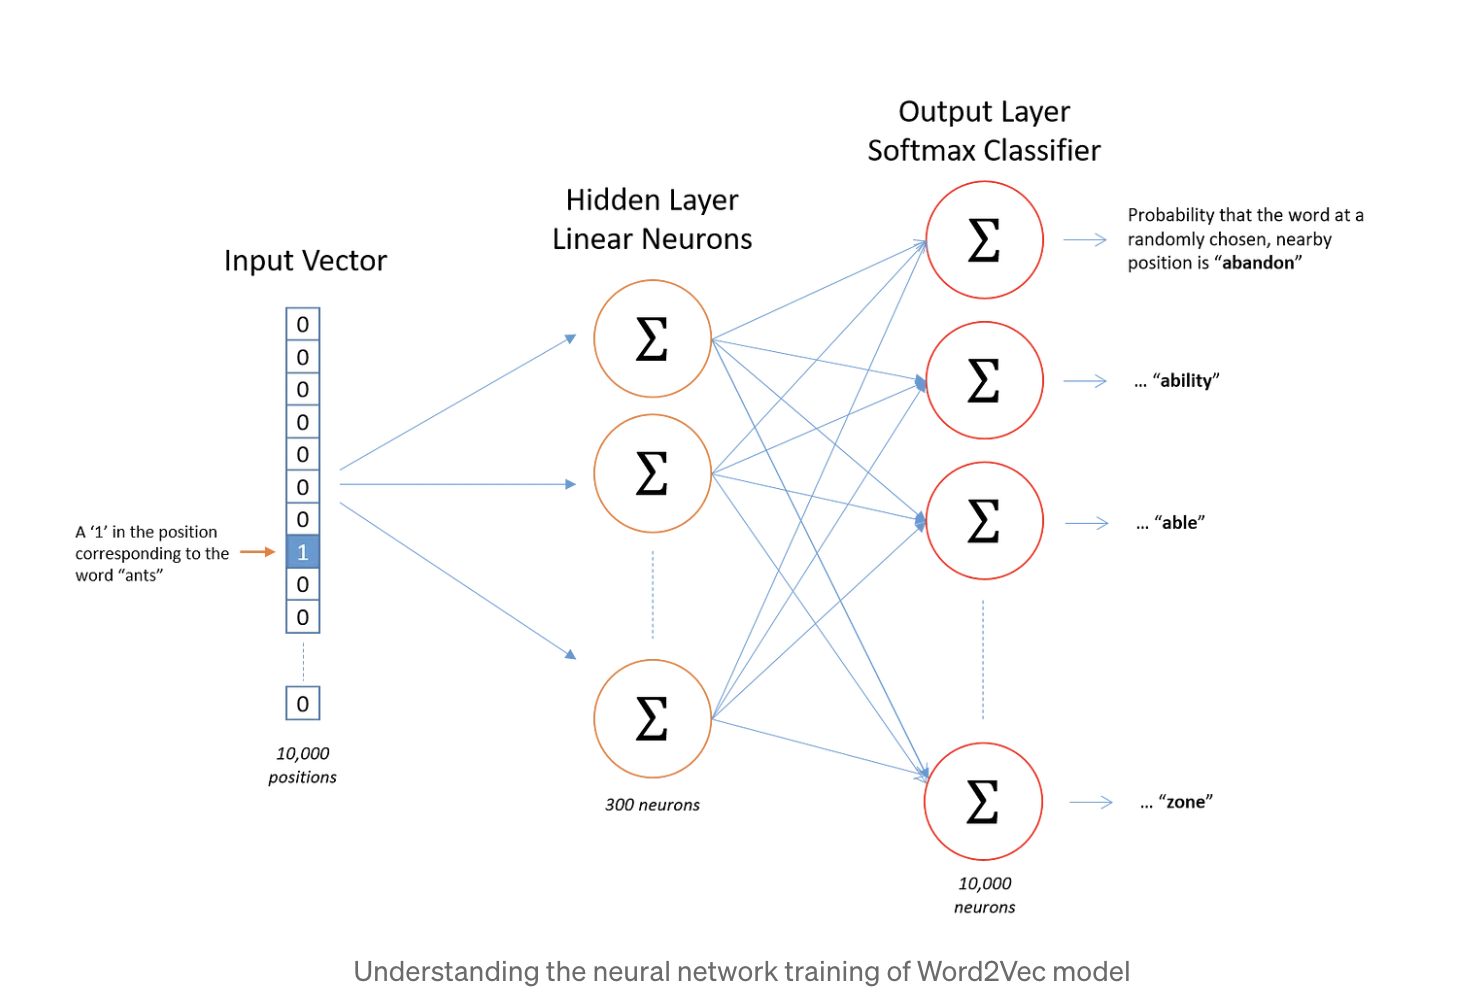

## There are two ways word embeddings can be developed: CBOW and Skipgram

## 1. Continuous Bag-Of-Words
- CBOW predicts the target-word based on its surrounding words.
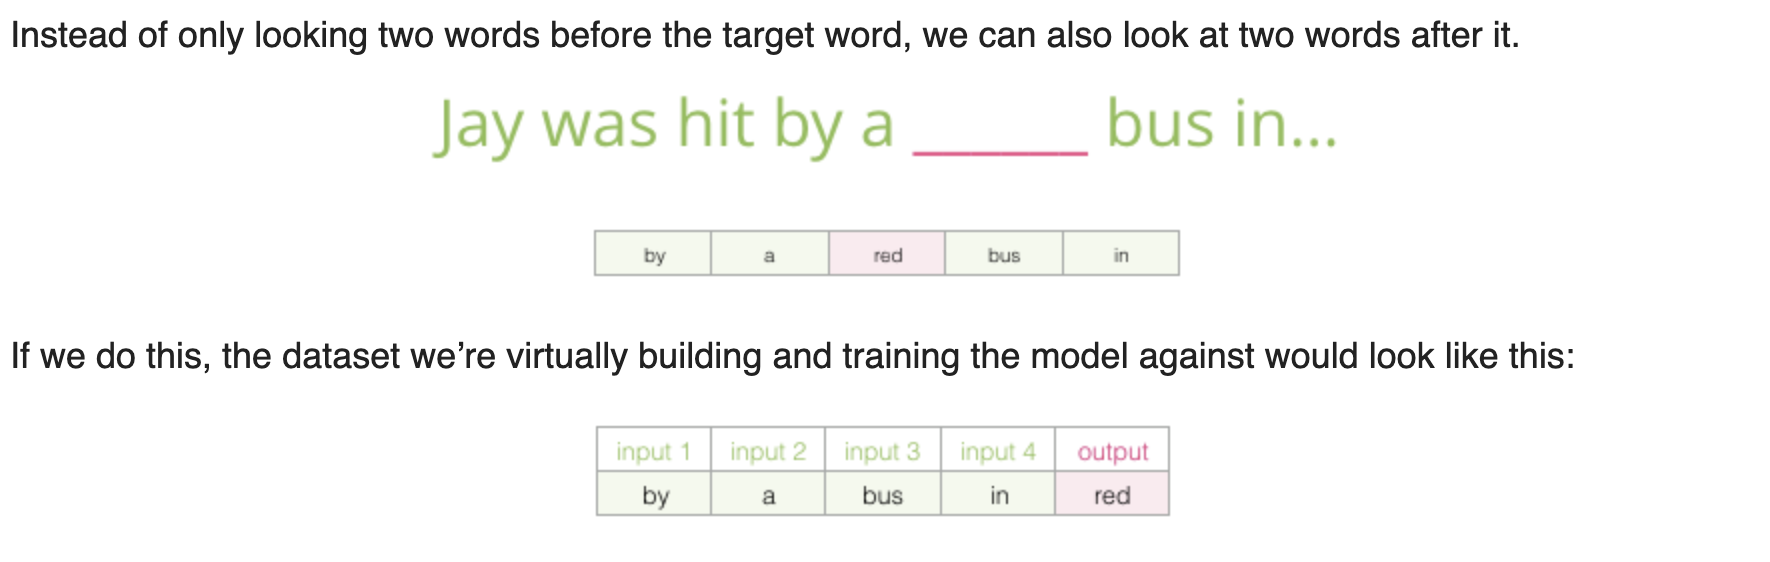
- CBOW is a faster algorithm than skipgrams and works well with frequent words

## 2. Skipgram
- Surrounding words are predicted of an input word
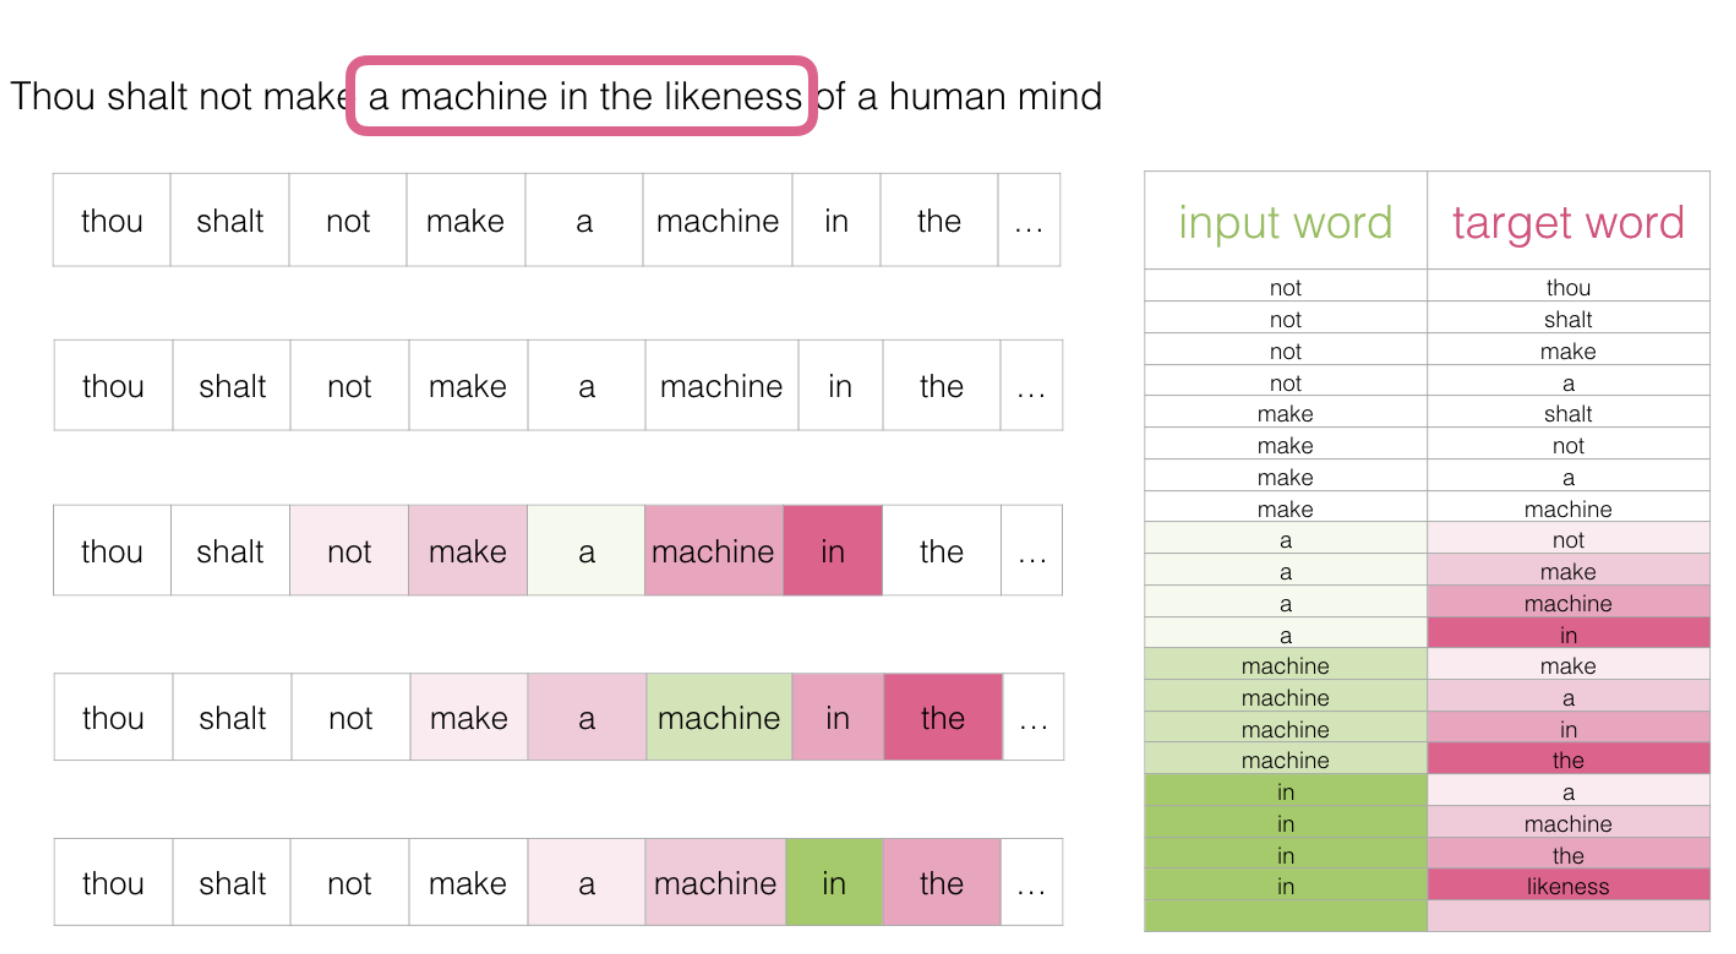
- Skipgrams work well with small datasets and can better represent less frequent words
- The problem with skipgram is that it is computationally very expensive as it calculates the probabilty of each word in the training set for each trining iteration.
-  What we do to resolve this is use  binary classification to predict if a word is a neighbour or not.
- There is another problem, if all our examples are positive(1) we will be building a model with 100% accuracy but spitting garbage embeddings.
- So we introduce negative sampling:  chosing random samples of words that are not neighbors. Our model needs to return 0 for those samples. 
![alt text](image.png)

- Two key hyperparameters in the word2vec training process are the window size and the number of negative samples
- Smaller window sizes (2-15) lead to embeddings where high similarity scores between two embeddings indicates that the words are interchangeable 
- Larger window sizes (15-50, or even more) lead to embeddings where similarity is more indicative of relatedness of the words
- Larger window sizes (15-50, or even more) lead to embeddings where similarity is more indicative of relatedness of the words.


# About the Dataset and Notebook

- The dataset used here is from kaggle: [dataset](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification?resource=download)
- Taking inspiration from the article : [article](https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673)
- It uses Gensim, a free open-source Python library for representing documents as semantic vectors


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
df = pd.read_csv('archive/Corona_NLP_train.csv', encoding='latin1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [44]:
df['OriginalTweet'].head().values

array(['@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8',
       'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P',
       "My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",
       "Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The 


# **Text Preprocessing Guide**  

## **When to Apply Preprocessing**  

| Preprocessing Step     | TF-IDF / CountVectorizer | Word2Vec / GloVe | BERT / Transformer Models |
|------------------------|-------------------------|------------------|---------------------------|
| **Lowercasing**       | Yes | Yes | No (BERT is case-sensitive) |
| **Stopword Removal**  | Yes | No (context matters) | No (BERT learns from stopwords) |
| **Punctuation Removal** | Yes | Yes (except for context-dependent cases) | No (BERT uses punctuation for meaning) |
| **Lemmatization**     | Yes | Optional (reduces vocabulary size) | No (BERT uses raw text) |
| **Stemming**         | No | No (destroys context) | No |
| **Tokenization**      | Yes | Yes (for training embeddings) | Yes (BERT requires subword tokenization) |
| **Removing Numbers**  | Yes (if irrelevant) | Depends (keep if numbers have meaning) | No |

---

## **When to Preprocess & When to Skip**  

### **1. Feature-Based NLP (TF-IDF, CountVectorizer)**  
- **Apply:** Lowercasing, stopword removal, punctuation removal, lemmatization.  
- **Skip:** Stemming (too aggressive), stopword removal (if some words hold meaning).  

### **2. Word Embeddings (Word2Vec, GloVe, fastText)**  
- **Apply:** Lowercasing, minimal punctuation removal, tokenization.  
- **Skip:** Stopword removal (they contribute to word context).  

### **3. Transformer-Based Models (BERT, RoBERTa, GPT)**  
- **Apply:** Tokenization (using subword models like WordPiece).  
- **Skip:** Lowercasing (unless using a cased model), stopword removal, punctuation removal, lemmatization.  

---

## **Key Takeaways**  
- **Rule-Based NLP (TF-IDF, CountVectorizer):** More preprocessing is better.  
- **Deep Learning Embeddings (Word2Vec, GloVe):** Preserve context, use minimal preprocessing.  
- **Transformer Models (BERT, GPT):** Avoid modifying text too much.  

Would you like a Python implementation guide for these steps?ions before we do text preprocessing:


In [45]:
df['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [46]:
## Keeping only the words in the tweets with no punctuation signs nor web links
import re
df['CleanTweet'] = df['OriginalTweet'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x))
df['CleanTweet'] = df['CleanTweet'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
df['CleanTweet'] = df['CleanTweet'].apply(lambda x: x.lower())
df['CleanTweet'].head().values

array(['menyrbie philgahan chrisitv  and  and ',
       'advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak ',
       'my food stock is not the only one which is empty\r\r\n\r\r\nplease dont panic there will be enough food for everyone if you do not take more than you need \r\r\nstay calm stay safe\r\r\n\r\r\ncovidfrance covid covid coronavirus confinement confinementotal confinementgeneral ',
       'me ready to go at supermarket during the covid outbreak\r\r\n\r\r\nnot because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage\r\r\n\r\r\ncoronavirusfrance restezchezvous stayathome confinement '],
      dtype=

In [47]:
import nltk
import spacy
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [48]:
#tokenuzing the tweets
nlp = spacy.load("en_core_web_sm")

df['TokenizedTweet'] = df['CleanTweet'].apply(lambda x: [token.text for token in nlp(x)])
df['TokenizedTweet'].head().values

array([list(['menyrbie', 'philgahan', 'chrisitv', ' ', 'and', ' ', 'and']),
       list(['advice', 'talk', 'to', 'your', 'neighbours', 'family', 'to', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'with', 'phone', 'numbers', 'of', 'neighbours', 'schools', 'employer', 'chemist', 'gp', 'set', 'up', 'online', 'shopping', 'accounts', 'if', 'poss', 'adequate', 'supplies', 'of', 'regular', 'meds', 'but', 'not', 'over', 'order']),
       list(['coronavirus', 'australia', 'woolworths', 'to', 'give', 'elderly', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'covid', 'outbreak']),
       list(['my', 'food', 'stock', 'is', 'not', 'the', 'only', 'one', 'which', 'is', 'empty', '\r\r\n\r\r\n', 'please', 'do', 'nt', 'panic', 'there', 'will', 'be', 'enough', 'food', 'for', 'everyone', 'if', 'you', 'do', 'not', 'take', 'more', 'than', 'you', 'need', '\r\r\n', 'stay', 'calm', 'stay', 'safe', '\r\r\n\r\r\n', 'covidfrance', 'covid', 'covid', 'coronavirus', 'confinement', 'confinement

In [49]:
# Lemmatization
df['CleanTweet'] = df['TokenizedTweet'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df.CleanTweet.head().values

array([list(['menyrbie', 'philgahan', 'chrisitv', ' ', 'and', ' ', 'and']),
       list(['advice', 'talk', 'to', 'your', 'neighbour', 'family', 'to', 'exchange', 'phone', 'number', 'create', 'contact', 'list', 'with', 'phone', 'number', 'of', 'neighbour', 'school', 'employer', 'chemist', 'gp', 'set', 'up', 'online', 'shopping', 'account', 'if', 'poss', 'adequate', 'supply', 'of', 'regular', 'med', 'but', 'not', 'over', 'order']),
       list(['coronavirus', 'australia', 'woolworth', 'to', 'give', 'elderly', 'disabled', 'dedicated', 'shopping', 'hour', 'amid', 'covid', 'outbreak']),
       list(['my', 'food', 'stock', 'is', 'not', 'the', 'only', 'one', 'which', 'is', 'empty', '\r\r\n\r\r\n', 'please', 'do', 'nt', 'panic', 'there', 'will', 'be', 'enough', 'food', 'for', 'everyone', 'if', 'you', 'do', 'not', 'take', 'more', 'than', 'you', 'need', '\r\r\n', 'stay', 'calm', 'stay', 'safe', '\r\r\n\r\r\n', 'covidfrance', 'covid', 'covid', 'coronavirus', 'confinement', 'confinementotal', 'con

In [50]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet,TokenizedTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,"[menyrbie, philgahan, chrisitv, , and, , and]","[menyrbie, philgahan, chrisitv, , and, , and]"
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,"[advice, talk, to, your, neighbour, family, to...","[advice, talk, to, your, neighbours, family, t..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,"[coronavirus, australia, woolworth, to, give, ...","[coronavirus, australia, woolworths, to, give,..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,"[my, food, stock, is, not, the, only, one, whi...","[my, food, stock, is, not, the, only, one, whi..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"[me, ready, to, go, at, supermarket, during, t...","[me, ready, to, go, at, supermarket, during, t..."


## Training a word2vec model

In [34]:
from gensim.models import Word2Vec

In [51]:
sentences = df['CleanTweet'].to_list()
print(sentences[:2])

[['menyrbie', 'philgahan', 'chrisitv', ' ', 'and', ' ', 'and'], ['advice', 'talk', 'to', 'your', 'neighbour', 'family', 'to', 'exchange', 'phone', 'number', 'create', 'contact', 'list', 'with', 'phone', 'number', 'of', 'neighbour', 'school', 'employer', 'chemist', 'gp', 'set', 'up', 'online', 'shopping', 'account', 'if', 'poss', 'adequate', 'supply', 'of', 'regular', 'med', 'but', 'not', 'over', 'order']]


- **Size** refers to the size of the word embedding that it would output.
- **Window** refers to the maximum distance between the current and predicted word within a sentence.
- **min_count** parameter is used to set a minimum frequency for the words to be a part of the model: i.e. it ignores all words with count less than min_count.
- **workers** uses those many worker threads to train the model. This can be adjusted as per the number of cores your system has. In simple words, it refers to parallelism while training the model.

In [53]:
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
sentences[:5]

[['menyrbie', 'philgahan', 'chrisitv', ' ', 'and', ' ', 'and'],
 ['advice',
  'talk',
  'to',
  'your',
  'neighbour',
  'family',
  'to',
  'exchange',
  'phone',
  'number',
  'create',
  'contact',
  'list',
  'with',
  'phone',
  'number',
  'of',
  'neighbour',
  'school',
  'employer',
  'chemist',
  'gp',
  'set',
  'up',
  'online',
  'shopping',
  'account',
  'if',
  'poss',
  'adequate',
  'supply',
  'of',
  'regular',
  'med',
  'but',
  'not',
  'over',
  'order'],
 ['coronavirus',
  'australia',
  'woolworth',
  'to',
  'give',
  'elderly',
  'disabled',
  'dedicated',
  'shopping',
  'hour',
  'amid',
  'covid',
  'outbreak'],
 ['my',
  'food',
  'stock',
  'is',
  'not',
  'the',
  'only',
  'one',
  'which',
  'is',
  'empty',
  '\r\r\n\r\r\n',
  'please',
  'do',
  'nt',
  'panic',
  'there',
  'will',
  'be',
  'enough',
  'food',
  'for',
  'everyone',
  'if',
  'you',
  'do',
  'not',
  'take',
  'more',
  'than',
  'you',
  'need',
  '\r\r\n',
  'stay',
  'calm',

In [56]:
# generate vocabulary
vocab = list(model.wv.index_to_key)
print(len(vocab))
print(vocab[:10])   

53786
['the', 'to', ' ', 'a', 'and', 'covid', 'of', 'in', 'coronavirus', 'for']


In [58]:
#word embedidng of coronavirus
print(model.wv['coronavirus'])

[-0.6219248   1.115869    2.2698517  -0.741378    2.0452392   1.1491098
  1.4479259   0.04356934 -1.4253811   0.10364018 -0.24748959  0.37892494
  0.48783585  0.88176113  0.9477056  -0.5910547   0.2011736   0.6659345
 -1.8369423  -1.8877223   0.7594709   1.532028    2.188351    0.16139407
 -0.6104799  -0.4444635   0.25320414 -1.0219903  -0.3396358  -1.0685668
  1.8934357  -2.194406    1.5075558  -0.579537   -1.4730121   3.2118473
  0.46872357  0.59402686 -0.32747993 -1.2529904  -0.7640633  -0.09986184
 -0.50750166  0.26343784 -0.641391   -0.43105853  0.42778805 -1.4251872
  0.11900824 -0.57496494  0.19142509 -1.1439726  -0.89402306  0.10294622
 -2.0810516  -1.1860924   0.9364231  -1.5011938   0.2482192  -1.1545563
  1.0474677  -0.61334336  1.9987416  -0.98656327 -0.11880574 -0.367749
 -0.35284916 -0.6590027  -0.43077424 -0.38755232 -0.19934222  0.5507818
  1.9438413   2.1424296  -1.1107342   0.264651   -0.51354253 -0.02901737
 -1.5973858  -1.3083491  -0.75302047 -0.1691279   0.362641  

In [60]:
#find similar words to coronavirus
print(model.wv.most_similar('coronavirus'))
print(model.wv.most_similar('putin'))
print(model.wv.most_similar('dose'))

[('coronacrisis', 0.7179761528968811), ('corona', 0.6948825716972351), ('covid', 0.6688435077667236), ('coronaviruspandemic', 0.624485433101654), ('shutaustraliadown', 0.6193776726722717), ('stopthespreadofcorona', 0.6164180040359497), ('kathkim', 0.6142368316650391), ('dinosaurextinction', 0.6100300550460815), ('stayathome', 0.6096799969673157), ('floridalockdown', 0.6090878844261169)]
[('vladimir', 0.9438202977180481), ('saudi', 0.9159601330757141), ('arabia', 0.9110658168792725), ('opec', 0.910908579826355), ('iran', 0.8984342813491821), ('tariff', 0.8957875370979309), ('russia', 0.8929608464241028), ('goldman', 0.8929480910301208), ('russian', 0.8916260600090027), ('agreement', 0.8898214101791382)]
[('gabrielsurfcat', 0.8680650591850281), ('yepbusiness', 0.8597991466522217), ('mattjo', 0.8594881892204285), ('wisconsin', 0.8574466705322266), ('athx', 0.8568660020828247), ('brendamkramer', 0.8560220003128052), ('breach', 0.8550879955291748), ('brandawareness', 0.8548779487609863), ('

In [ ]:
# finding analogy
print(model.wv.most_similar(positive=["coronavirus", "putin"], negative=["dose"])) #
print(model.wv.most_similar(positive=["coronavirus", "putin"], negative=["virus"]))
print(model.wv.most_similar(positive=["coronavirus", "putin"], negative=["covid"]))


[('robboheraldsun', 0.597052276134491), ('rakamoto', 0.5570140480995178), ('waechterrandall', 0.5499376654624939), ('corona', 0.5398184061050415), ('stayingcalm', 0.5352856516838074), ('fighttogether', 0.5203646421432495), ('coronavirusny', 0.5175132155418396), ('kooomo', 0.5162250399589539), ('shutaustraliadown', 0.516196072101593), ('missionaccomplished', 0.5150655508041382)]
[('xylene', 0.7595511674880981), ('obrien', 0.7538756728172302), ('chairwoman', 0.7460579872131348), ('oilandgas', 0.7449753880500793), ('aramco', 0.7392619252204895), ('alexander', 0.7386968731880188), ('rivercityoms', 0.7384682893753052), ('cryptocurrency', 0.7347432971000671), ('mining', 0.7336251139640808), ('asx', 0.7304489016532898)]
[('vladimir', 0.7579192519187927), ('incompetent', 0.7431594729423523), ('unitedsecurities', 0.7314978837966919), ('kitconews', 0.7263048887252808), ('pandumbic', 0.7234411239624023), ('chin', 0.7166916728019714), ('j', 0.7125493884086609), ('senatorburr', 0.7110164165496826),

In [62]:
#findin the odd one out
print(model.wv.doesnt_match(['coronavirus', 'putin', 'dose'])) 
print(model.wv.doesnt_match(['coronavirus', 'putin', 'covid']))
print(model.wv.doesnt_match(['coronavirus', 'putin', 'virus'])) 


coronavirus
putin
putin
